**Kaia Quigg Final Project DSP 562**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

**Data Cleaning**

In [2]:
df = pd.read_csv('Global Ecological Footprint 2023.csv', encoding='latin1')

In [3]:
df = df.rename(columns={
    'Built up land': 'Built-up land EF',
    'Built up land.1': 'Built-up land BC',
    'Total biocapacity ': 'Total Biocapacity',
    'Life Exectancy': 'Life Expectancy'
})

In [4]:
print(df.columns)

Index(['Country', 'Region', 'SDGi', 'Life Expectancy', 'HDI', 'Per Capita GDP',
       'Income Group', 'Population (millions)', 'Cropland Footprint',
       'Grazing Footprint', 'Forest Product Footprint', 'Carbon Footprint',
       'Fish Footprint', 'Built-up land EF',
       'Total Ecological Footprint (Consumption)', 'Cropland', 'Grazing land',
       'Forest land', 'Fishing ground', 'Built-up land BC',
       'Total Biocapacity', 'Ecological (Deficit) or Reserve',
       'Number of Earths required', 'Number of Countries required'],
      dtype='object')


In [5]:
# Identify missing values

missing_locations = df.isnull().stack().reset_index()
missing_locations.columns = ['Country Index', 'Column', 'Is Missing']
missing_locations = missing_locations[missing_locations['Is Missing']]
missing_locations['Country'] = df.loc[missing_locations['Country Index'], 'Country'].values
missing_locations = missing_locations.drop(columns='Is Missing')

missing_locations = missing_locations[['Country', 'Column', 'Country Index']]

unique_countries_with_missing_values = missing_locations['Country'].unique()

In [6]:
print(f'Number of unique countries with missing values: {len(unique_countries_with_missing_values)}')

print('\nLocations of missing values:')
print(missing_locations['Column'].value_counts())

Number of unique countries with missing values: 48

Locations of missing values:
Grazing Footprint                           30
Built-up land EF                            30
Fishing ground                              30
Grazing land                                30
Forest Product Footprint                    30
Built-up land BC                            30
Fish Footprint                              30
Cropland Footprint                          30
Forest land                                 30
Cropland                                    30
Carbon Footprint                            30
SDGi                                        23
Per Capita GDP                              17
HDI                                          9
Life Expectancy                              6
Income Group                                 4
Total Ecological Footprint (Consumption)     1
Ecological (Deficit) or Reserve              1
Total Biocapacity                            1
Number of Countries requir

In [7]:
land_type_columns = [
    'Grazing land', 'Grazing Footprint', 'Fish Footprint', 'Cropland Footprint',
    'Built-up land BC', 'Forest Product Footprint', 'Carbon Footprint', 
    'Cropland', 'Built-up land EF', 'Forest land', 'Fishing ground'
]

In [8]:
land_type_missing = missing_locations[missing_locations['Column'].isin(land_type_columns)]

In [9]:
countries_of_interest = land_type_missing['Country'].unique()
print('\n'.join(countries_of_interest))

Antigua and Barbuda
Bermuda
Cabo Verde
Cambodia
Comoros
Cyprus
Dominica
Ecuador
Egypt
French Guiana
French Polynesia
Grenada
Guadeloupe
Guyana
Honduras
Lesotho
Malta
Martinique
Mauritius
Netherlands
New Zealand
Republic of Moldova
Réunion
Saint Vincent and Grenadines
Samoa
Sao Tome and Principe
Solomon Islands
Tonga
Ukraine
Vanuatu


In [10]:
# Examining which region countries belong to
filtered_df = df[df['Country'].isin(countries_of_interest)]
region_counts = filtered_df['Region'].value_counts()
print(region_counts)

Asia-Pacific                 7
Africa                       7
Central America/Caribbean    7
EU-27                        3
South America                3
Other Europe                 2
North America                1
Name: Region, dtype: int64


In [11]:
region_counts_original = df['Region'].value_counts()
print(region_counts_original)

Africa                       53
Asia-Pacific                 30
EU-27                        26
Middle East/Central Asia     23
Central America/Caribbean    20
South America                13
Other Europe                 13
North America                 4
Name: Region, dtype: int64


In [12]:
print(df['Country'].count())

182


In [13]:
df = df[~df['Country'].isin(countries_of_interest)]

In [14]:
print(df['Country'].count())

152


In [15]:
# Imputing regional median to remaining missing values

def convert_gdp_to_float(df, col):
    df[col] = df[col].astype(str)  
    df[col] = df[col].str.strip()  
    df[col] = df[col].replace('[\$,]', '', regex=True)  
    df[col] = pd.to_numeric(df[col], errors='coerce')  
    return df


def identify_non_numeric(df, cols):
    non_numeric = {}
    for col in cols:
        non_numeric_values = df[~df[col].apply(lambda x: pd.to_numeric(x, errors='coerce')).notna()][col]
        if not non_numeric_values.empty:
            non_numeric[col] = non_numeric_values
    return non_numeric


def fill_with_regional_median(df, group_col, target_cols):
    for col in target_cols:
        df[col] = df.groupby(group_col)[col].transform(lambda x: x.fillna(x.median()))
    return df


df = convert_gdp_to_float(df, 'Per Capita GDP')


numerical_columns = ['Per Capita GDP', 'SDGi']  

non_numeric_values = identify_non_numeric(df, numerical_columns)
for col, values in non_numeric_values.items():
    print(f"Non-numeric values in column {col}:")
    print(values)

for col in numerical_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = fill_with_regional_median(df, 'Region', numerical_columns)

Non-numeric values in column Per Capita GDP:
0     NaN
40    NaN
42    NaN
89    NaN
95    NaN
157   NaN
158   NaN
169   NaN
175   NaN
177   NaN
180   NaN
181   NaN
Name: Per Capita GDP, dtype: float64
Non-numeric values in column SDGi:
40        
52     NaN
53     NaN
72     NaN
89     NaN
138    NaN
148    NaN
161    NaN
163    NaN
174    NaN
180    NaN
181    NaN
Name: SDGi, dtype: object


In [16]:
missing_values = df.isnull().sum()
print(missing_values)

Country                                     0
Region                                      0
SDGi                                        0
Life Expectancy                             2
HDI                                         3
Per Capita GDP                              0
Income Group                                0
Population (millions)                       0
Cropland Footprint                          0
Grazing Footprint                           0
Forest Product Footprint                    0
Carbon Footprint                            0
Fish Footprint                              0
Built-up land EF                            0
Total Ecological Footprint (Consumption)    0
Cropland                                    0
Grazing land                                0
Forest land                                 0
Fishing ground                              0
Built-up land BC                            0
Total Biocapacity                           0
Ecological (Deficit) or Reserve   

In [17]:
df['Life Expectancy'] = df['Life Expectancy'].astype(str)
df['HDI'] = df['HDI'].astype(str)

df['Life Expectancy'] = df['Life Expectancy'].str.strip()  
df['Life Expectancy'] = df['Life Expectancy'].replace('', np.nan)

df['HDI'] = df['HDI'].str.strip() 
df['HDI'] = df['HDI'].replace('', np.nan) 


df['Life Expectancy'] = pd.to_numeric(df['Life Expectancy'], errors='coerce')
df['HDI'] = pd.to_numeric(df['HDI'], errors='coerce')

In [18]:
remaining_numerical_cols = ['Life Expectancy', 'HDI']

df = fill_with_regional_median(df, 'Region', remaining_numerical_cols)

missing_values_after_fill = df.isnull().sum()
print("Missing values after filling with regional median:")
print(missing_values_after_fill)

Missing values after filling with regional median:
Country                                     0
Region                                      0
SDGi                                        0
Life Expectancy                             0
HDI                                         0
Per Capita GDP                              0
Income Group                                0
Population (millions)                       0
Cropland Footprint                          0
Grazing Footprint                           0
Forest Product Footprint                    0
Carbon Footprint                            0
Fish Footprint                              0
Built-up land EF                            0
Total Ecological Footprint (Consumption)    0
Cropland                                    0
Grazing land                                0
Forest land                                 0
Fishing ground                              0
Built-up land BC                            0
Total Biocapacity            

In [19]:
income_mapping = {'HI': 3, 'LI': 0, 'LM': 1, 'UM': 2}

df['Income Group'] = df['Income Group'].map(income_mapping)

print(df[['Income Group']])

     Income Group
0               0
1               2
2               2
3               1
5               2
..            ...
177             2
178             1
179             1
180             1
181             0

[152 rows x 1 columns]


**Research Question 1**

In [20]:
#Summary statistics
columns_of_interest = ['Total Ecological Footprint (Consumption)', 'Total Biocapacity', 'Per Capita GDP', 'HDI', 'Income Group']

summary_stats = df[columns_of_interest].agg(['mean', 'median', 'std', lambda x: x.max() - x.min()]).transpose()
summary_stats.columns = ['Mean', 'Median', 'Standard Deviation', 'Range']

print(summary_stats)

                                                  Mean        Median  \
Total Ecological Footprint (Consumption)      3.048026      2.300000   
Total Biocapacity                             2.962998      1.386204   
Per Capita GDP                            21030.151316  14715.500000   
HDI                                           0.712138      0.730000   
Income Group                                  1.598684      2.000000   

                                          Standard Deviation          Range  
Total Ecological Footprint (Consumption)            2.326153      12.500000  
Total Biocapacity                                   6.622550      74.734325  
Per Capita GDP                                  22439.609135  119772.000000  
HDI                                                 0.158912       0.570000  
Income Group                                        1.105434       3.000000  


In [21]:
# Correlation

corr = df[columns_of_interest].corr(method = 'spearman')

print(corr)

                                          Total Ecological Footprint (Consumption)  \
Total Ecological Footprint (Consumption)                                  1.000000   
Total Biocapacity                                                         0.457382   
Per Capita GDP                                                            0.868234   
HDI                                                                       0.856025   
Income Group                                                              0.844002   

                                          Total Biocapacity  Per Capita GDP  \
Total Ecological Footprint (Consumption)           0.457382        0.868234   
Total Biocapacity                                  1.000000        0.303385   
Per Capita GDP                                     0.303385        1.000000   
HDI                                                0.304118        0.950867   
Income Group                                       0.323840        0.906091   

        

In [22]:
# Regression

X = df[['Per Capita GDP', 'HDI']]
y = df['Total Ecological Footprint (Consumption)']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                                       OLS Regression Results                                       
Dep. Variable:     Total Ecological Footprint (Consumption)   R-squared:                       0.672
Model:                                                  OLS   Adj. R-squared:                  0.667
Method:                                       Least Squares   F-statistic:                     152.6
Date:                                      Thu, 06 Feb 2025   Prob (F-statistic):           8.77e-37
Time:                                              12:11:50   Log-Likelihood:                -258.80
No. Observations:                                       152   AIC:                             523.6
Df Residuals:                                           149   BIC:                             532.7
Df Model:                                                 2                                         
Covariance Type:                                  nonrobust                                

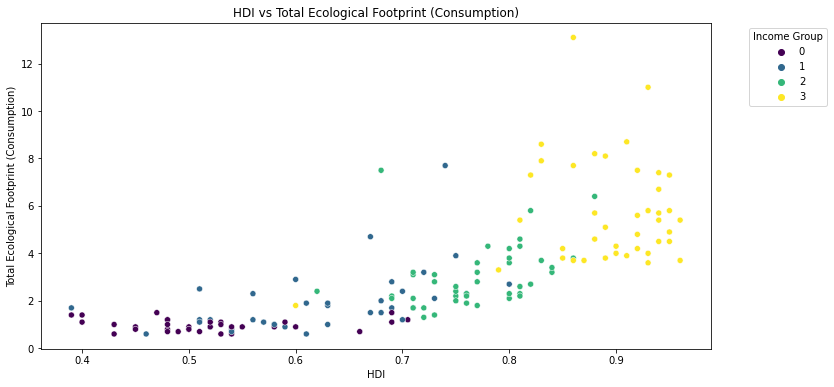

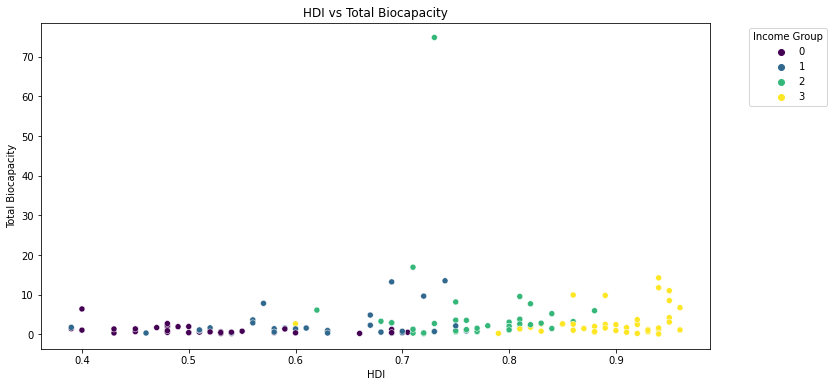

In [23]:
#Graphics

# HDI vs Total Ecological Footprint
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='HDI', y='Total Ecological Footprint (Consumption)', hue='Income Group', palette='viridis')
plt.title('HDI vs Total Ecological Footprint (Consumption)')
plt.xlabel('HDI')
plt.ylabel('Total Ecological Footprint (Consumption)')
plt.legend(title='Income Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# HDI vs Total Biocapacity
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='HDI', y='Total Biocapacity', hue='Income Group', palette='viridis')
plt.title('HDI vs Total Biocapacity')
plt.xlabel('HDI')
plt.ylabel('Total Biocapacity')
plt.legend(title='Income Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**Research Question 2**

In [24]:
# Regional Differences in resource use

# Avg EF by region by land type
avg_eco_footprints = df.groupby('Region').mean()[[
    'Cropland Footprint', 'Grazing Footprint', 
    'Forest Product Footprint', 
    'Fish Footprint', 'Built-up land EF'
]]

# Avg BC by region by land type
avg_biocapacity = df.groupby('Region').mean()[[
    'Cropland', 'Grazing land', 
    'Forest land', 'Fishing ground', 
    'Built-up land BC'
]]

print("Average Ecological Footprints by Region:")
print(avg_eco_footprints)

print("\nAverage Biocapacity by Region:")
print(avg_biocapacity)

Average Ecological Footprints by Region:
                           Cropland Footprint  Grazing Footprint  \
Region                                                             
Africa                               0.371739           0.236957   
Asia-Pacific                         0.434783           0.308696   
Central America/Caribbean            0.469231           0.176923   
EU-27                                1.052174           0.260870   
Middle East/Central Asia             0.573913           0.230435   
North America                        1.033333           0.266667   
Other Europe                         0.890909           0.209091   
South America                        0.510000           0.640000   

                           Forest Product Footprint  Fish Footprint  \
Region                                                                
Africa                                     0.282609        0.054348   
Asia-Pacific                               0.347826        0.1478

In [25]:
# Data exported to Tableau for further manipulation/visualization
avg_eco_footprints.to_csv('average_ecological_footprints.csv', index=True)
avg_biocapacity.to_csv('average_biocapacity.csv', index=True)

In [26]:
# Normalizing by population
df['Population (millions)'] = pd.to_numeric(df['Population (millions)'], errors='coerce')

df['Total Cropland Footprint'] = df['Cropland Footprint'] * df['Population (millions)']
df['Total Grazing Footprint'] = df['Grazing Footprint'] * df['Population (millions)']
df['Total Forest Product Footprint'] = df['Forest Product Footprint'] * df['Population (millions)']
df['Total Fish Footprint'] = df['Fish Footprint'] * df['Population (millions)']
df['Total Built-up Land Footprint'] = df['Built-up land EF'] * df['Population (millions)']

df['Total Cropland Biocapacity'] = df['Cropland'] * df['Population (millions)']
df['Total Grazing Biocapacity'] = df['Grazing land'] * df['Population (millions)']
df['Total Forest Biocapacity'] = df['Forest land'] * df['Population (millions)']
df['Total Fishing Biocapacity'] = df['Fishing ground'] * df['Population (millions)']
df['Total Built-up Land Biocapacity'] = df['Built-up land BC'] * df['Population (millions)']

In [27]:
# Calculate differences for each resource type
df['Difference Cropland'] = df['Total Cropland Biocapacity'] - df['Total Cropland Footprint']
df['Difference Grazing'] = df['Total Grazing Biocapacity'] - df['Total Grazing Footprint']
df['Difference Forest'] = df['Total Forest Biocapacity'] - df['Total Forest Product Footprint']
df['Difference Fishing'] = df['Total Fishing Biocapacity'] - df['Total Fish Footprint']
df['Difference Built-up Land'] = df['Total Built-up Land Biocapacity'] - df['Total Built-up Land Footprint']

# Group by region and aggregate differences
regional_differences = df.groupby('Region').agg({
    'Difference Cropland': 'sum',
    'Difference Grazing': 'sum',
    'Difference Forest': 'sum',
    'Difference Fishing': 'sum',
    'Difference Built-up Land': 'sum',
}).reset_index()

# Print aggregated regional differences to compare
print(regional_differences)


                      Region  Difference Cropland  Difference Grazing  \
0                     Africa               -38.11              161.47   
1               Asia-Pacific               -57.55              107.60   
2  Central America/Caribbean               -13.86               -0.17   
3                      EU-27               -58.99              -42.43   
4   Middle East/Central Asia               -67.71               14.57   
5              North America               161.36              -33.48   
6               Other Europe                75.96               21.12   
7              South America               103.94              123.55   

   Difference Forest  Difference Fishing  Difference Built-up Land  
0          75.878887           45.962941                 20.725129  
1          77.735594          110.243312                -11.022036  
2           0.745432            2.628775                  0.235764  
3         162.214338           16.147960                 -6.581579

In [28]:
# Exported to Tableau
regional_differences.to_csv('regional_differences.csv', index=False)

**Research Question 3**

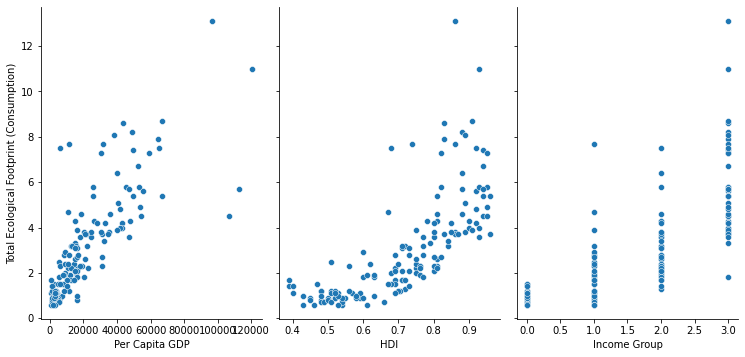

In [29]:
# Scatter plots to visualize predictors
sns.pairplot(df, x_vars=['Per Capita GDP', 'HDI', 'Income Group'], y_vars='Total Ecological Footprint (Consumption)', height=5, aspect=0.7)
plt.show()

In [30]:
# Build model
X = df[['Per Capita GDP', 'HDI', 'Income Group']]
y_ef = df['Total Ecological Footprint (Consumption)']

X = pd.get_dummies(X, drop_first=True)
X = sm.add_constant(X)

In [31]:
# Split data
X_train_ef, X_test_ef, y_train_ef, y_test_ef = train_test_split(X, y_ef, test_size=0.2, random_state=12)

In [32]:
# Run model
model_ef = sm.OLS(y_train_ef, X_train_ef).fit()
print(model_ef.summary())

                                       OLS Regression Results                                       
Dep. Variable:     Total Ecological Footprint (Consumption)   R-squared:                       0.645
Model:                                                  OLS   Adj. R-squared:                  0.636
Method:                                       Least Squares   F-statistic:                     70.77
Date:                                      Thu, 06 Feb 2025   Prob (F-statistic):           3.59e-26
Time:                                              12:11:51   Log-Likelihood:                -207.34
No. Observations:                                       121   AIC:                             422.7
Df Residuals:                                           117   BIC:                             433.9
Df Model:                                                 3                                         
Covariance Type:                                  nonrobust                                

In [33]:
# Predict and evaluate
y_pred_ef = model_ef.predict(X_test_ef)

print(f'EF Model R^2: {r2_score(y_test_ef, y_pred_ef)}')
print(f'EF Model RMSE: {np.sqrt(mean_squared_error(y_test_ef, y_pred_ef))}')

EF Model R^2: 0.7808239800802158
EF Model RMSE: 1.1646677492542148


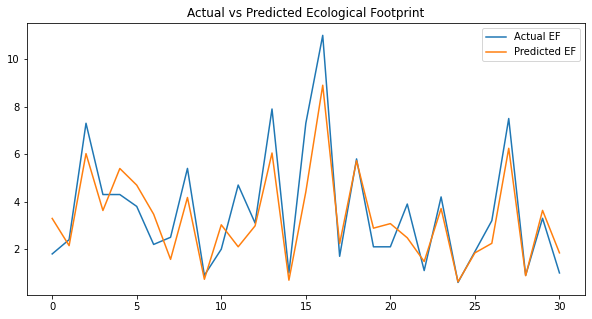

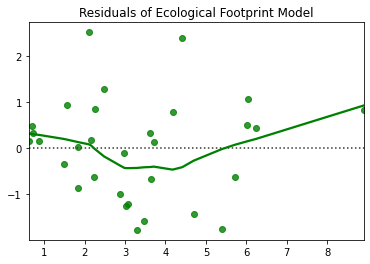

In [34]:
# Visualize 

# Actual vs Predicted values for EF
plt.figure(figsize=(10, 5))
plt.plot(y_test_ef.values, label='Actual EF')
plt.plot(y_pred_ef.values, label='Predicted EF')
plt.legend()
plt.title('Actual vs Predicted Ecological Footprint')
plt.show()

# Residual plots for EF
residuals_ef = y_test_ef - y_pred_ef
sns.residplot(x=y_pred_ef, y=residuals_ef, lowess=True, color='g')
plt.title('Residuals of Ecological Footprint Model')
plt.show()
